In [29]:
import pandas as pd

In [1]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from unicodedata import normalize

def preprocess(name):
    name = name.replace('fප', 'ෆ')
    name = name.replace('Fප', 'ෆ')
    name = list(name)
    vowels = "අ ආ ඇ ඈ ඉ ඊ උ ඌ ඍ ඎ ඏ ඐ එ ඒ ඓ ඔ ඕ ඖ".split()
    consonants = "ක ඛ ග ඝ ඞ ඟ ච ඡ ජ ඣ ඤ ඥ ඦ ට ඨ ඩ ඪ ණ ඬ ත ථ ද ධ න ඳ ප ඵ බ භ ම ඹ ය ර ල ව ශ ෂ ස හ ළ ෆ".split()
    cannot_followed_by_pillam = "ආ ඇ ඈ ඉ ඊ ඌ ඍ ඎ ඐ ඒ ඓ ඕ ඖ".split()
    can_followed_by_only_a_specific_pillam = "අ උ ඏ එ ඔ".split()
    pillam = "්  ා ැ ෑ ි ී ු  ූ  ෘ ෙ ේ ෛ ො ෝ ෞ  ෲ ෳ".split()
    pillam_cannot_followed_by_pillam = "්  ා ැ ෑ ි ී ු  ූ  ෘ  ේ ෛ ෝ ෞ  ෲ ෳ".split()
    pillam_can_followed_by_only_specific_pillam = " ා  ෙ ො".split()
    preprocessed_name = ''
    i = 0
    while True:
        if(i > len(name) - 1):
            break
        character = name[i]
        next_character = name[i+1] if i < len(name) - 1 else None
        previous_character = name[i-1] if i > 0 else None
        if(character in pillam):
            if(previous_character == None or previous_character in cannot_followed_by_pillam or previous_character in pillam_cannot_followed_by_pillam):
                name.pop(i)
                i -= 1
            elif(not any([(previous_character in consonants),
                          (previous_character ==
                           can_followed_by_only_a_specific_pillam[0] and character == pillam[1]),
                          (previous_character ==
                 can_followed_by_only_a_specific_pillam[1] and character == pillam[-1]),
                          (previous_character ==
                 can_followed_by_only_a_specific_pillam[2] and character == pillam[-1]),
                          (previous_character == can_followed_by_only_a_specific_pillam[3] and (
                    character == pillam[0] or character == pillam[9])),
                (previous_character == can_followed_by_only_a_specific_pillam[3] and (
                    character == pillam[0] or character == pillam[-1])),
                (previous_character ==
                 pillam_can_followed_by_only_specific_pillam[0] and character == pillam[0]),
                (previous_character == pillam_can_followed_by_only_specific_pillam[1] and (
                    character == pillam[0] or character == pillam[1])),
                (previous_character ==
                 pillam_can_followed_by_only_specific_pillam[2] and character == pillam[0]),
            ])):
                name.pop(i)
            else:
                preprocessed_name += character if(3456 <
                                                  ord(character) < 3583) else ''
        elif(character == '\u200d' and (previous_character != pillam[0] or (next_character != 'ර' and next_character != 'ය'))):
            name.pop(i)
            i -= 1
        else:
            preprocessed_name += character if(3456 < ord(character)
                                              < 3583 or character == '\u200d') else ''
        i += 1
    return normalize("NFC", preprocessed_name)


def tokenize(text):
    text = preprocess(text)
    suffixesList = ["්", "ා", "ැ", "ෑ", "ි", "ී", "ු",
                    "ූ", "ෙ", "ේ", "ෛ", "ො", "ෝ", "ෞ", "ෘ", "ෲ"]
    tokens = []
    li = 1
    while li < len(text):
        prevChar, currentChar = text[li - 1], text[li]
        if(currentChar == '\u200d'):
            if(li < len(text) - 1):
                if(prevChar == suffixesList[0] and (text[li + 1] == 'ර' or text[li + 1] == 'ය' or text[li + 1] == 'ද')):
                    tokens.append(tokens.pop()+currentChar+text[li + 1])
                    li += 1
        elif(currentChar in suffixesList):
            if(li != 1):
                tokens.append(f"{tokens.pop()}{currentChar}")
            else:
                tokens.append(f"{prevChar}{currentChar}")
        else:
            if(li == 1):
                tokens.append(prevChar)
            tokens.append(currentChar)
        li += 1
    return tokens

In [5]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(init_token='<s>', eos_token='</s>', tokenize=tokenize, include_lengths=True, batch_first=True)
fields = [('name', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=r'D:\Final Year Project\Codes\FYP-Omega\Data\Neural_Classifier_Data', train=r'Train\classification_training_names.csv', validation=r'Train\classification_validation_names.csv', test=r'Test\classification_testing_names.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.name),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.name),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.name),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train)

In [6]:
class LSTM(nn.Module):

    def __init__(self, vocab, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [7]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [8]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = './',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for ((name, name_len), labels), _ in train_loader:           
            labels = labels.to(device)
            name = name.to(device)
            name_len = name_len.to('cpu')
            # print(name_len)
            output = model(name, name_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for ((name, name_len), labels), _ in valid_loader:
                      labels = labels.to(device)
                      name = name.to(device)
                      name_len = name_len.to('cpu')
                      output = model(name, name_len)

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/lstm-minibatch-tokenized-classifier-model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/lstm-minibatch-tokenized-classifier-metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/lstm-minibatch-tokenized-classifier-metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM(text_field.vocab).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10, file_path=r'Saved_Models')

Epoch [1/10], Step [23075/461510], Train Loss: 0.0202, Valid Loss: 8.4230
Model saved to ==> Saved_Models/lstm-minibatch-tokenized-classifier-model.pt
Model saved to ==> Saved_Models/lstm-minibatch-tokenized-classifier-metrics.pt
Epoch [1/10], Step [46150/461510], Train Loss: 0.0511, Valid Loss: 0.9924
Model saved to ==> Saved_Models/lstm-minibatch-tokenized-classifier-model.pt
Model saved to ==> Saved_Models/lstm-minibatch-tokenized-classifier-metrics.pt
Epoch [2/10], Step [69225/461510], Train Loss: 0.0423, Valid Loss: 5.5000
Epoch [2/10], Step [92300/461510], Train Loss: 0.0681, Valid Loss: 1.2537
Epoch [3/10], Step [115375/461510], Train Loss: 0.0420, Valid Loss: 7.4719
Epoch [3/10], Step [138450/461510], Train Loss: 0.0678, Valid Loss: 1.2788
Epoch [4/10], Step [161525/461510], Train Loss: 0.0442, Valid Loss: 5.6037
Epoch [4/10], Step [184600/461510], Train Loss: 0.0771, Valid Loss: 1.3178
Epoch [5/10], Step [207675/461510], Train Loss: 0.0476, Valid Loss: 8.2188
Epoch [5/10], Ste

Model loaded from <== ./Saved_Models/lstm-minibatch-tokenized-classifier-metrics.pt


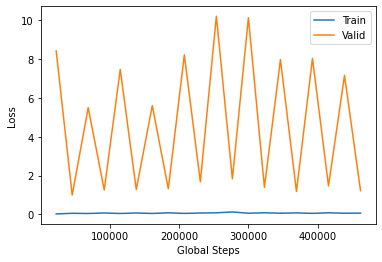

In [8]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(r'./Saved_Models/lstm-minibatch-tokenized-classifier-metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model loaded from <== ./Saved_Models/lstm-minibatch-tokenized-classifier-model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9014    0.1219    0.2148    109823
           0     0.4924    0.9846    0.6565     95002

    accuracy                         0.5220    204825
   macro avg     0.6969    0.5533    0.4356    204825
weighted avg     0.7117    0.5220    0.4197    204825



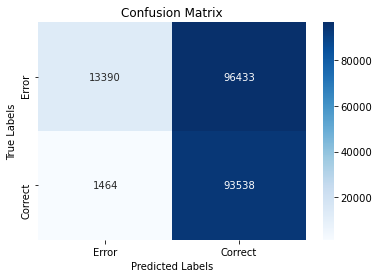

In [8]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((name, name_len), labels), _ in test_loader:           
            labels = labels.to(device)
            name = name.to(device)
            name_len = name_len.to('cpu')
            output = model(name, name_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Error', 'Correct'])
    ax.yaxis.set_ticklabels(['Error', 'Correct'])
    
    
best_model = LSTM(text_field.vocab).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(r'./Saved_Models/lstm-minibatch-tokenized-classifier-model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Classification Report:
              precision    recall  f1-score   support

           1     0.8551    0.2267    0.3584    109823
           0     0.5167    0.9556    0.6707     95002

    accuracy                         0.5648    204825
   macro avg     0.6859    0.5912    0.5146    204825
weighted avg     0.6981    0.5648    0.5033    204825



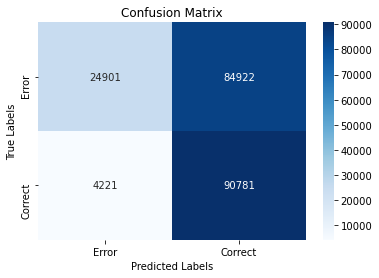

In [10]:
evaluate(best_model, test_iter, threshold=0.4)

Classification Report:
              precision    recall  f1-score   support

           1     0.6476    0.7236    0.6835     45000
           0     0.7741    0.7064    0.7387     60344

    accuracy                         0.7138    105344
   macro avg     0.7109    0.7150    0.7111    105344
weighted avg     0.7201    0.7138    0.7151    105344



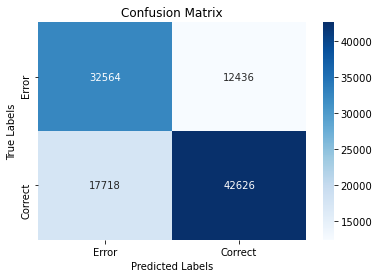

In [ ]:
evaluate(model, test_iter, threshold=0.3)

Classification Report:
              precision    recall  f1-score   support

           1     0.7404    0.5062    0.6013    109823
           0     0.5820    0.7949    0.6720     95002

    accuracy                         0.6401    204825
   macro avg     0.6612    0.6505    0.6366    204825
weighted avg     0.6669    0.6401    0.6341    204825



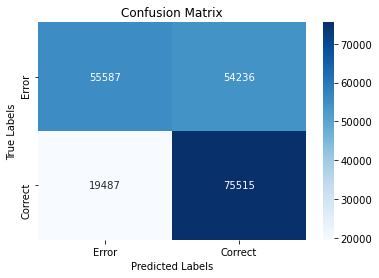

In [11]:
evaluate(best_model, test_iter, threshold=0.2)

Classification Report:
              precision    recall  f1-score   support

           1     0.6888    0.7644    0.7246    109823
           0     0.6881    0.6008    0.6415     95002

    accuracy                         0.6885    204825
   macro avg     0.6884    0.6826    0.6831    204825
weighted avg     0.6885    0.6885    0.6861    204825



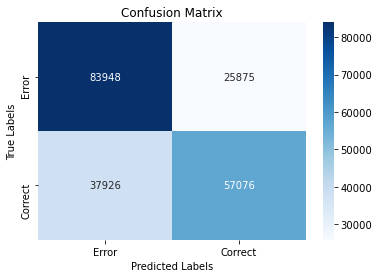

In [12]:
evaluate(best_model, test_iter, threshold=0.1)

In [ ]:
i = 0
for ((name, name_len), labels), _ in test_iter: 
  if(i > 98):
    print(name)
    print(name_len)
  i+=1
  if(i == 100):
    break

tensor([[  2,  58,   8,  46,   3],
        [  2,  92,  23,  11,   3],
        [  2,  20,  63,   4,   3],
        [  2,  26,  50,  24,   3],
        [  2, 246,   6,  54,   3],
        [  2,  35,  44,  34,   3],
        [  2,  17,   7,   5,   3],
        [  2,  78, 179,  19,   3],
        [  2,  89,  72,  58,   3],
        [  2,  36,  83,   9,   3],
        [  2, 143,  18,  55,   3],
        [  2,  26,  82,   6,   3],
        [  2,  45,  30,   6,   3],
        [  2,  18,  10,  16,   3],
        [  2,  45,  30,   6,   3],
        [  2,   9, 116,  35,   3],
        [  2,  21, 101,  88,   3],
        [  2,  59, 151,  20,   3],
        [  2,   6,   7,  20,   3],
        [  2,  26, 118,  12,   3],
        [  2,  85, 120,  68,   3],
        [  2,  18, 347,  46,   3],
        [  2,  33,  36,  19,   3],
        [  2,  17,  10, 146,   3],
        [  2,  52,  49,  38,   3],
        [  2,  30,  27,   9,   3],
        [  2,  53,  62,  38,   3],
        [  2,  89, 390,   6,   3],
        [  2,  50,  

In [ ]:
for i in [ 2, 19,  5, 28, 20,  3]:
  print(text_field.vocab.itos[i])


<s>
ත්
ගේ
ත
නි
</s>


In [18]:
best_model.eval()
threshold = 0.4
name = 'නමල්'
name, name_len = text_field.numericalize((name, [len(name)]))
with torch.no_grad():         
    name = torch.cat((torch.tensor([[2]]), name.reshape((1,-1)), torch.tensor([[3]])), 1).to(device)
    name_len = name_len.to('cpu')
    print(name)
    print(name_len)  
    # print(name_len.shape)
    # print(type(name_len))
    output = best_model(name, name_len)
    print(output)
    output = (output > threshold).int()
    print(output)

tensor([[ 2, 11,  6, 12,  0,  3]])
tensor([4])
tensor([0.9573])
tensor([1], dtype=torch.int32)


In [13]:
def get_accuracy(error, original):
    best_model.eval()
    original, original_len = text_field.numericalize((original, [len(original)]))
    error, error_len = text_field.numericalize((error, [len(error)]))
    with torch.no_grad():  
        original = torch.cat((torch.tensor([[2]]), original.reshape((1,-1)), torch.tensor([[3]])), 1).to(device)
        error = torch.cat((torch.tensor([[2]]), error.reshape((1,-1)), torch.tensor([[3]])), 1).to(device)
        original_len = original_len.to('cpu')
        error_len = error_len.to('cpu')
        original_output = best_model(original, original_len)
        error_output = best_model(error, error_len)
        return  error_output.item(), original_output.item()

In [14]:
from os.path import isfile, join, join
from os import listdir
import json

path = 'D:\Final Year Project\Codes\FYP-Omega\Data\Error_Data\ocr_error_data\OCR errors testing'
files = [f for f in listdir(path) if isfile(join(path, f))]

raw_names_ocr = []
for file in files:
  raw_names_ocr +=  open(join(path, file), encoding='utf-8').readlines()[1:]
raw_names_ocr = ''.join(raw_names_ocr)

normalized_raw_names_ocr = normalize('NFC', raw_names_ocr.strip())
normalized_name_list_ocr = normalized_raw_names_ocr.split('\n')

difference = 0
possitive_differences = 0
results = []
for i, line in enumerate(normalized_name_list_ocr):
    original, error_malith, error_abhaya = line.split(',')
    original, error_malith, error_abhaya = normalize('NFC', original), normalize('NFC', error_malith), normalize('NFC', error_abhaya)
    
    if(original != error_malith):
        try:
            error_name_accuracy, original_name_accuracy = get_accuracy(error_malith, original)
            norm_difference = (original_name_accuracy - error_name_accuracy)/original_name_accuracy
            difference += norm_difference
            if norm_difference>0:
                possitive_differences+=1
            results.append({"original_name": original, "error_name": error_malith, "error_name_accuracy":error_name_accuracy, "original_name_accuracy": original_name_accuracy, "normalized_difference": norm_difference})
        except:
            pass
    if(original != error_abhaya):
        try:
            error_name_accuracy, original_name_accuracy = get_accuracy(error_abhaya, original)
            norm_difference = (original_name_accuracy - error_name_accuracy)/original_name_accuracy
            difference += norm_difference
            if norm_difference>0:
                possitive_differences+=1
            results.append({"original_name": original, "error_name": error_abhaya, "error_name_accuracy":error_name_accuracy, "original_name_accuracy": original_name_accuracy, "normalized_difference": norm_difference})
        except:
            pass

with open("evaluation_lstm_cls_language_model_ocr.json", "w", encoding='utf-8') as outfile:
    json.dump({"final_socre": difference/len(results), "positives": possitive_differences/len(results), "results": results}, outfile, ensure_ascii=False)